# Notebook 03: DFT Setup Fundamentals

## Making the Right Choices Before Calculations

This notebook covers the critical decisions you must make before running DFT calculations:
- Exchange-correlation functional
- Pseudopotential selection
- Cutoff energies
- K-point sampling

---

## 1. Exchange-Correlation Functionals — Jacob's Ladder

In DFT, the **total energy** of a system is written as:

$$E[\rho] = T_s[\rho] + E_{\text{ext}}[\rho] + E_H[\rho] + E_{xc}[\rho]$$

Every term except $E_{xc}$ is known exactly. The **exchange-correlation (XC) functional** $E_{xc}[\rho]$ is the *only approximation* in DFT — it encodes all the many-body quantum mechanics we cannot solve exactly.

### Jacob's Ladder of XC Functionals

John Perdew organized XC functionals into a hierarchy called **Jacob's Ladder** (2001), where each rung adds more physical information and (usually) more accuracy — at higher computational cost:

| Rung | Name | Ingredients | Examples | Typical Error |
|:----:|------|-------------|----------|---------------|
| 1 | **LDA** | $\rho(\mathbf{r})$ only | PZ, PW, VWN | Lattice: −1 to −3% |
| 2 | **GGA** | $\rho + \nabla\rho$ | **PBE**, PBEsol, RPBE, BLYP | Lattice: +1 to +2% |
| 3 | **meta-GGA** | $\rho + \nabla\rho + \tau$ | **SCAN**, r²SCAN, TPSS | Lattice: ~0.5% |
| 4 | **Hybrid** | + exact exchange | **HSE06**, PBE0, B3LYP | Band gap: ~0.3 eV |
| 5 | **Double hybrid / RPA** | + unoccupied orbitals | RPA, MP2 | Chemical accuracy |

> **Key point**: $\tau(\mathbf{r}) = \frac{1}{2}\sum_i |\nabla\psi_i|^2$ is the kinetic energy density — this is what distinguishes meta-GGA from GGA.

### Important: XC Functional ≠ Pseudopotential

This is a **common misconception**. They are two completely different things:

| | **XC Functional** | **Pseudopotential** |
|---|---|---|
| **What it is** | Approximation to $E_{xc}[\rho]$ | Replacement for core electrons |
| **Set in** | QE input file (`input_dft`) | Generated *once* by `ld1.x` |
| **Affects** | Total energy, forces, all physics | Wavefunction smoothness near nuclei |
| **Examples** | PBE, SCAN, HSE06 | `Si.pbe-n-rrkjus_psl.1.0.0.UPF` |

A pseudopotential is **generated using a specific XC functional** (e.g., PBE). The naming `Si.pbe-...` tells you which functional was used to *construct* it. You should **use a PP that matches your calculation's functional** — but the PP itself is not the functional.

> **Analogy**: The XC functional is the *recipe* (physics model). The pseudopotential is a *pre-cooked ingredient* (core electrons already solved). You need the ingredient to be prepared with the same recipe you're cooking with.

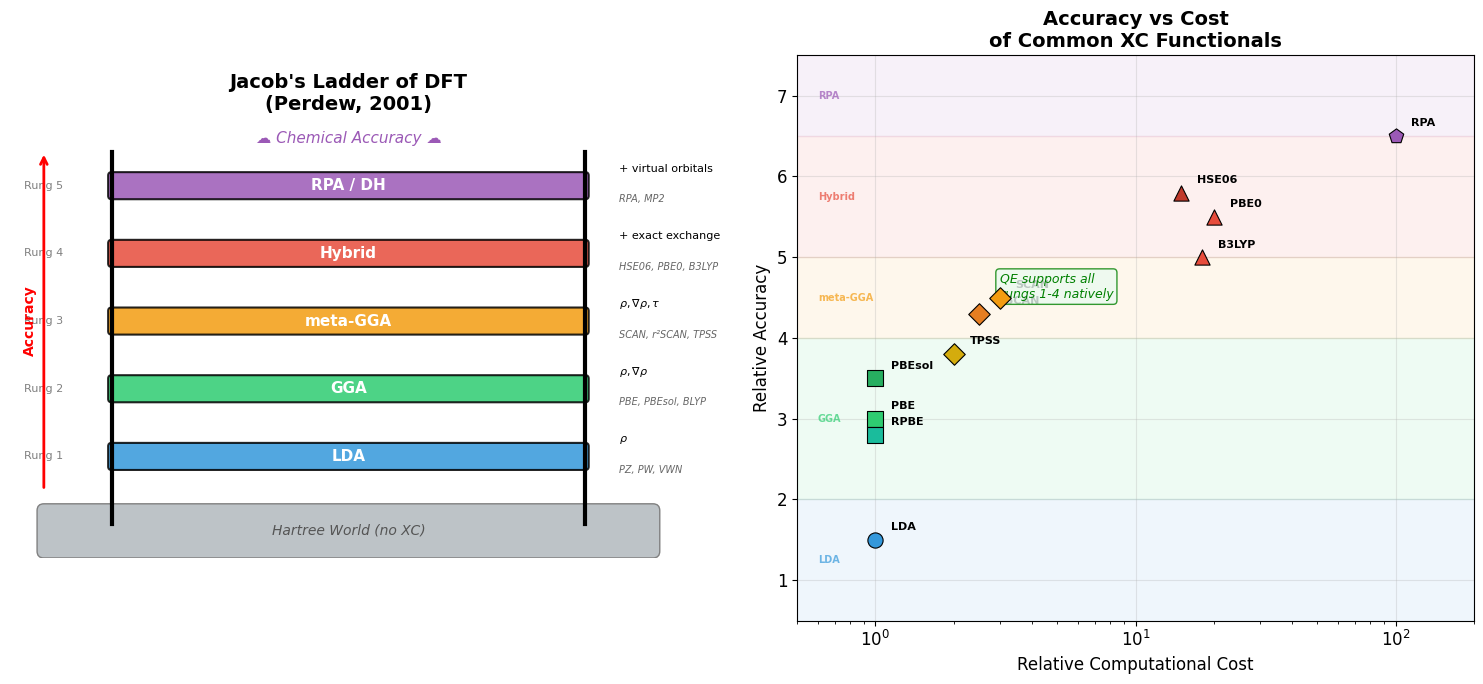


Key takeaways:
  • GGA (PBE) is the workhorse — good accuracy at minimal cost
  • meta-GGA (SCAN) gives better energetics for ~2-3× cost
  • Hybrids (HSE06) are needed for accurate band gaps but 10-20× more expensive
  • In QE: functional is set via input_dft keyword, NOT by changing the pseudopotential


In [3]:
# =============================================================================
# JACOB'S LADDER OF XC FUNCTIONALS — Visual Overview
# =============================================================================

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

fig, axes = plt.subplots(1, 2, figsize=(15, 7))

# ── Left panel: Jacob's Ladder schematic ──
ax1 = axes[0]
ax1.set_xlim(0, 10)
ax1.set_ylim(-0.5, 6)
ax1.set_aspect('equal')
ax1.axis('off')
ax1.set_title("Jacob's Ladder of DFT\n(Perdew, 2001)", fontsize=14, fontweight='bold')

rungs = [
    (1, 'LDA',      r'$\rho$',                    'PZ, PW, VWN',        '#3498db'),
    (2, 'GGA',      r'$\rho, \nabla\rho$',        'PBE, PBEsol, BLYP',  '#2ecc71'),
    (3, 'meta-GGA', r'$\rho, \nabla\rho, \tau$',  'SCAN, r²SCAN, TPSS', '#f39c12'),
    (4, 'Hybrid',   r'+ exact exchange',           'HSE06, PBE0, B3LYP', '#e74c3c'),
    (5, 'RPA / DH', r'+ virtual orbitals',         'RPA, MP2',           '#9b59b6'),
]

# Draw ladder posts
ax1.plot([1.5, 1.5], [0, 5.5], 'k-', linewidth=3)
ax1.plot([8.5, 8.5], [0, 5.5], 'k-', linewidth=3)

# Ground ("Hartree world")
ax1.add_patch(patches.FancyBboxPatch((0.5, -0.4), 9, 0.6,
              boxstyle="round,pad=0.1", facecolor='#bdc3c7', edgecolor='gray'))
ax1.text(5, -0.1, 'Hartree World (no XC)', ha='center', va='center',
         fontsize=10, style='italic', color='#555')

# Draw rungs
for rung_num, name, ingredients, examples, color in rungs:
    y = rung_num * 1.0
    # Rung bar
    ax1.add_patch(patches.FancyBboxPatch((1.5, y - 0.15), 7, 0.3,
                  boxstyle="round,pad=0.05", facecolor=color, edgecolor='k',
                  alpha=0.85, linewidth=1.5))
    # Labels
    ax1.text(5, y, f'{name}', ha='center', va='center',
             fontsize=11, fontweight='bold', color='white')
    ax1.text(0.2, y, f'Rung {rung_num}', ha='left', va='center',
             fontsize=8, color='gray')
    ax1.text(9.0, y + 0.25, ingredients, ha='left', va='center', fontsize=8)
    ax1.text(9.0, y - 0.2, examples, ha='left', va='center', fontsize=7,
             color='#666', style='italic')

# Arrow: accuracy increases upward
ax1.annotate('', xy=(0.5, 5.5), xytext=(0.5, 0.5),
             arrowprops=dict(arrowstyle='->', color='red', lw=2))
ax1.text(0.3, 3.0, 'Accuracy', rotation=90, ha='center', va='center',
         fontsize=10, color='red', fontweight='bold')

# "Chemical accuracy" heaven
ax1.text(5, 5.7, '☁ Chemical Accuracy ☁', ha='center', va='center',
         fontsize=11, color='#9b59b6', style='italic')

# ── Right panel: Accuracy vs Cost scatter ──
ax2 = axes[1]

functionals = {
    'LDA':     {'acc': 1.5, 'cost': 1.0, 'color': '#3498db', 'marker': 'o'},
    'PBE':     {'acc': 3.0, 'cost': 1.0, 'color': '#2ecc71', 'marker': 's'},
    'PBEsol':  {'acc': 3.5, 'cost': 1.0, 'color': '#27ae60', 'marker': 's'},
    'RPBE':    {'acc': 2.8, 'cost': 1.0, 'color': '#1abc9c', 'marker': 's'},
    'SCAN':    {'acc': 4.5, 'cost': 3.0, 'color': '#f39c12', 'marker': 'D'},
    'r²SCAN':  {'acc': 4.3, 'cost': 2.5, 'color': '#e67e22', 'marker': 'D'},
    'TPSS':    {'acc': 3.8, 'cost': 2.0, 'color': '#d4ac0d', 'marker': 'D'},
    'PBE0':    {'acc': 5.5, 'cost': 20,  'color': '#e74c3c', 'marker': '^'},
    'HSE06':   {'acc': 5.8, 'cost': 15,  'color': '#c0392b', 'marker': '^'},
    'B3LYP':   {'acc': 5.0, 'cost': 18,  'color': '#e74c3c', 'marker': '^'},
    'RPA':     {'acc': 6.5, 'cost': 100, 'color': '#9b59b6', 'marker': 'p'},
}

for name, props in functionals.items():
    ax2.scatter(props['cost'], props['acc'], s=120, c=props['color'],
                marker=props['marker'], edgecolors='k', linewidths=0.8, zorder=5)
    offset = (0.15, 0.15) if props['cost'] < 50 else (-5, 0.15)
    ax2.annotate(name, (props['cost'], props['acc']),
                 xytext=(props['cost']*1.15, props['acc']+0.12),
                 fontsize=8, fontweight='bold')

ax2.set_xscale('log')
ax2.set_xlabel('Relative Computational Cost', fontsize=12)
ax2.set_ylabel('Relative Accuracy', fontsize=12)
ax2.set_title('Accuracy vs Cost\nof Common XC Functionals', fontsize=14, fontweight='bold')
ax2.set_xlim(0.5, 200)
ax2.set_ylim(0.5, 7.5)
ax2.grid(True, alpha=0.3)

# Add rung shading
for y_lo, y_hi, color, label in [(0.5, 2.0, '#3498db', 'LDA'),
                                   (2.0, 4.0, '#2ecc71', 'GGA'),
                                   (4.0, 5.0, '#f39c12', 'meta-GGA'),
                                   (5.0, 6.5, '#e74c3c', 'Hybrid'),
                                   (6.5, 7.5, '#9b59b6', 'RPA')]:
    ax2.axhspan(y_lo, y_hi, alpha=0.08, color=color)
    ax2.text(0.6, (y_lo+y_hi)/2, label, fontsize=7, color=color, alpha=0.7,
             va='center', fontweight='bold')

# QE support annotation
ax2.annotate('QE supports all\nrungs 1-4 natively',
             xy=(3, 4.5), fontsize=9, color='green', style='italic',
             bbox=dict(boxstyle='round,pad=0.3', facecolor='#eafaf1', edgecolor='green', alpha=0.8))

plt.tight_layout()
plt.savefig('jacobs_ladder.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nKey takeaways:")
print("  • GGA (PBE) is the workhorse — good accuracy at minimal cost")
print("  • meta-GGA (SCAN) gives better energetics for ~2-3× cost")
print("  • Hybrids (HSE06) are needed for accurate band gaps but 10-20× more expensive")
print("  • In QE: functional is set via input_dft keyword, NOT by changing the pseudopotential")

In [4]:
# =============================================================================
# SETUP - Run this cell first
# =============================================================================

import sys
from pathlib import Path

_cwd = Path.cwd().resolve()
if (_cwd / 'workshop_setup.py').exists():
    sys.path.insert(0, str(_cwd))
elif (_cwd / 'notebooks_enhanced' / 'workshop_setup.py').exists():
    sys.path.insert(0, str(_cwd / 'notebooks_enhanced'))
else:
    raise FileNotFoundError("Cannot find workshop_setup.py. Run from the workshop root or notebooks_enhanced/")

from workshop_setup import *

from pymatgen.core import Structure, Lattice
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer

import spglib

from ase import Atoms
from ase.build import bulk
from ase.io import read, write

print_workshop_banner()

print("\nSSP Cutoff Recommendations (from SSSP v1.3 Efficiency):")
print("=" * 60)
print(f"{'Element':<10} {'ecutwfc (Ry)':<15} {'ecutrho factor':<15}")
print("-" * 40)
for elem in ['Si', 'Al', 'Fe', 'O', 'Ti', 'Sr', 'Cu', 'N']:
    if elem in SSSP_EFFICIENCY:
        ecut, dual, _ = SSSP_EFFICIENCY[elem]
        print(f"{elem:<10} {ecut:<15} {dual}x")
print("=" * 60)

/home/niel/.local/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


QUANTUM ESPRESSO WORKSHOP - SETUP

Paths:
  Workshop root:     /home/niel/git/DFT_Tutorial/qe_workshop_complete
  Pseudopotentials:  /home/niel/git/DFT_Tutorial/qe_workshop_complete/pseudopotentials
  Output directory:  /home/niel/git/DFT_Tutorial/qe_workshop_complete/outputs

QE Executables:
  pw.x:    /home/niel/src/qe-7.5/bin/pw.x
  MPI:     /usr/bin/mpirun
  NPROCS:  8

Available functionals: PBE, LDA, PBEsol
Elements in database: PBE(68), LDA(20), PBEsol(34)

SSP Cutoff Recommendations (from SSSP v1.3 Efficiency):
Element    ecutwfc (Ry)    ecutrho factor 
----------------------------------------
Si         40              8x
Al         30              8x
Fe         90              12x
O          75              8x
Ti         60              8x
Sr         40              8x
Cu         55              8x
N          80              8x


---

## 2. Pseudopotentials — What They Are and How to Choose Them

### Why Pseudopotentials?

In an atom, core electrons (e.g., 1s² in carbon) are:
- **Tightly bound** to the nucleus — energies ~100-1000× larger than valence
- **Chemically inert** — they don't participate in bonding
- **Oscillatory** near the nucleus — requiring extremely fine grids to represent

A **pseudopotential (PP)** replaces the nucleus + core electrons with an effective potential that:
1. Reproduces the correct scattering properties for valence electrons
2. Produces smooth, nodeless pseudo-wavefunctions below a cutoff radius $r_c$
3. Dramatically reduces the plane-wave basis set needed

### The Three Generations of Pseudopotentials

| Type | Full Name | How It Works | `ecutrho` | Accuracy | Use Case |
|:----:|-----------|-------------|:---------:|:--------:|----------|
| **NC** | Norm-Conserving | Pseudo-wavefunction has same norm as AE inside $r_c$ | 4× `ecutwfc` | Good | Quick tests, response functions |
| **US** | Ultrasoft (Vanderbilt) | Relaxes norm conservation → smoother PPs | 8-12× `ecutwfc` | Good | General purpose, lower cutoffs |
| **PAW** | Projector Augmented Wave | Reconstructs full AE wavefunction on demand | 8× `ecutwfc` | Best | Production calculations, hyperfine properties |

> **PAW** is generally recommended for production work. It gives all-electron accuracy at pseudopotential cost.

### Decoding the PP Filename

Every QE pseudopotential filename follows a systematic naming convention:

```
  C . pbe - n - kjpaw_psl . 1.0.0 . UPF
  │    │    │      │          │       │
  │    │    │      │          │       └── Format: Unified Pseudopotential Format
  │    │    │      │          └────────── Version: PSlibrary version
  │    │    │      └───────────────────── Type + Library:
  │    │    │                               kjpaw = PAW (Kresse-Joubert PAW)
  │    │    │                               rrkjus = US (Rappe-Rabe-Kaxiras-Joannopoulos US)
  │    │    │                               _psl = from PSlibrary
  │    │    └──────────────────────────── Valence config:
  │    │                                    n = [Ne] core (2s²2p² valence)
  │    │                                    dn = includes d electrons
  │    │                                    spn = includes semi-core s,p
  │    │                                    spdn = includes semi-core s,p,d
  │    └───────────────────────────────── XC Functional used to generate PP:
  │                                         pbe = PBE (GGA)
  │                                         pz = LDA (Perdew-Zunger)
  │                                         pbesol = PBEsol
  └────────────────────────────────────── Element symbol
```

### More Examples

| Filename | Element | Functional | Valence | PP Type |
|----------|---------|-----------|---------|---------|
| `H.pbe-rrkjus_psl.1.0.0.UPF` | H | PBE | all (1 electron) | Ultrasoft |
| `Fe.pbe-spn-kjpaw_psl.1.0.0.UPF` | Fe | PBE | 3s²3p⁶3d⁶4s² (semi-core) | PAW |
| `Si.pbesol-n-rrkjus_psl.1.0.0.UPF` | Si | PBEsol | 3s²3p² | Ultrasoft |
| `Ti.pz-spn-kjpaw_psl.1.0.0.UPF` | Ti | LDA | 3s²3p⁶3d²4s² (semi-core) | PAW |
| `Si.pz-vbc.UPF` | Si | LDA | 3s²3p² | NC (old-style) |

### Valence Configuration — When Semi-core Matters

The valence configuration code tells you which electrons are treated explicitly:

| Code | Meaning | When Needed |
|------|---------|-------------|
| `n` | Standard valence only | Light elements (C, N, O, Si) |
| `dn` | Includes d electrons | Post-transition metals (Ga, Ge, In, Sn) |
| `spn` | Semi-core s and p | Transition metals (Ti, Fe, Ni) — **important for accuracy** |
| `spdn` | Semi-core s, p, and d | Lanthanides, actinides |
| `nl`, `spnl` | Non-linear core correction variants | Elements with large core-valence overlap |

> **Rule of thumb**: For transition metals, **always use semi-core PPs** (`spn`). The 3s and 3p electrons overlap with 3d and affect bonding significantly.

### PP Libraries and Where to Get Them

| Library | Source | Coverage | Notes |
|---------|--------|----------|-------|
| **PSlibrary** | [pseudopotentials.quantum-espresso.org](https://pseudopotentials.quantum-espresso.org/) | Full periodic table | Standard QE library, PAW and US |
| **SSSP** | [Materials Cloud](https://www.materialscloud.org/discover/sssp) | ~90 elements | Curated with tested cutoffs |
| **GBRV** | [Garrity et al.](https://www.physics.rutgers.edu/gbrv/) | ~60 elements | Optimized US potentials |
| **SG15** | [Schlipf & Gygi](http://www.quantum-simulation.org/potentials/sg15_oncv/) | ~80 elements | Optimized NC (ONCV) |

### Critical Rule: PP Must Match Your XC Functional

When you set `input_dft = 'PBE'` in QE, you **must** use a PP generated with PBE (filename contains `.pbe-`). Mixing functionals (e.g., PBE PP with LDA calculation) introduces **uncontrolled errors** because the PP encodes the functional's behavior in the core region.

In [6]:
# =============================================================================
# PSEUDOPOTENTIAL ANATOMY — Parse and understand any PP file
# =============================================================================

from workshop_setup import *

print("=" * 70)
print("PSEUDOPOTENTIAL ANATOMY — Understanding PP Files")
print("=" * 70)

# Show naming convention breakdown for common PPs
examples = [
    ('C.pbe-n-kjpaw_psl.1.0.0.UPF',   'Carbon',    'PBE', 'standard valence',     'PAW'),
    ('Fe.pbe-spn-kjpaw_psl.1.0.0.UPF', 'Iron',      'PBE', 'semi-core s,p',        'PAW'),
    ('Si.pbe-n-rrkjus_psl.1.0.0.UPF',  'Silicon',   'PBE', 'standard valence',     'Ultrasoft'),
    ('Ge.pbe-dn-kjpaw_psl.1.0.0.UPF',  'Germanium', 'PBE', 'includes d electrons', 'PAW'),
    ('H.pz-rrkjus_psl.1.0.0.UPF',      'Hydrogen',  'LDA', 'all (1 electron)',     'Ultrasoft'),
]

print(f"\n{'Filename':<45} {'Elem':>4} {'XC':>7} {'Valence':<22} {'Type':<10}")
print("-" * 95)
for fn, elem, xc, val, pptype in examples:
    print(f"{fn:<45} {elem:>4} {xc:>7} {val:<22} {pptype:<10}")

# Parse a REAL PP file if available
print("\n" + "=" * 70)
print("PARSING A REAL PP FILE (from your local library)")
print("=" * 70)

pp_dir = PSEUDO_DIR / 'PBE'
sample_files = sorted(pp_dir.glob('*.UPF'))[:3] if pp_dir.exists() else []

for pp_file in sample_files:
    info = parse_upf_header(pp_file)
    print(f"\n  File: {info['filename']}")
    print(f"  Element:      {info['element']}")
    print(f"  Functional:   {info['functional']}")
    print(f"  PP Type:      {info['pp_type']}")
    print(f"  ecutwfc:      {info['ecutwfc']} Ry" if info['ecutwfc'] else "  ecutwfc:      (not specified)")
    print(f"  ecutrho:      {info['ecutrho']} Ry" if info['ecutrho'] else "  ecutrho:      (not specified)")
    print(f"  Relativistic: {info['relativistic']}")

# Show available elements
print("\n" + "=" * 70)
print("AVAILABLE PSEUDOPOTENTIALS IN YOUR LIBRARY")
print("=" * 70)
for func in ['PBE', 'LDA', 'PBEsol']:
    elems = list_available_elements(func)
    print(f"\n  {func} ({len(elems)} elements):")
    print(f"    {', '.join(elems)}")

print("\n" + "=" * 70)
print("KEY TAKEAWAY")
print("=" * 70)
print("""
  The pseudopotential and the XC functional are DIFFERENT things:
  
  • XC Functional = physics model for electron-electron interaction
    → Set in QE input: input_dft = 'PBE' (or auto-detected from PP)
  
  • Pseudopotential = pre-computed effective potential for core electrons
    → Generated ONCE with a specific functional (encoded in filename)
    → Must MATCH the functional you use in your calculation
  
  Think of it this way:
    XC functional = the recipe you're cooking with
    Pseudopotential = a pre-prepared ingredient (must match the recipe)
""")

PSEUDOPOTENTIAL ANATOMY — Understanding PP Files

Filename                                      Elem      XC Valence                Type      
-----------------------------------------------------------------------------------------------
C.pbe-n-kjpaw_psl.1.0.0.UPF                   Carbon     PBE standard valence       PAW       
Fe.pbe-spn-kjpaw_psl.1.0.0.UPF                Iron     PBE semi-core s,p          PAW       
Si.pbe-n-rrkjus_psl.1.0.0.UPF                 Silicon     PBE standard valence       Ultrasoft 
Ge.pbe-dn-kjpaw_psl.1.0.0.UPF                 Germanium     PBE includes d electrons   PAW       
H.pz-rrkjus_psl.1.0.0.UPF                     Hydrogen     LDA all (1 electron)       Ultrasoft 

PARSING A REAL PP FILE (from your local library)

  File: Al.pbe-nl-kjpaw_psl.1.0.0.UPF
  Element:      Al
  Functional:   PBE
  PP Type:      PAW
  ecutwfc:      29.0 Ry
  ecutrho:      121.0 Ry
  Relativistic: True

  File: Ar.pbe-n-kjpaw_psl.1.0.0.UPF
  Element:      Ar
  Funct

---

## 3. K-point Sampling

### Rules of Thumb

- **Metals**: Dense grids needed (12×12×12 or more)
- **Semiconductors**: Moderate (6×6×6 to 8×8×8)
- **Insulators**: Coarser grids sufficient (4×4×4 to 6×6×6)
- **Large cells**: Fewer k-points needed (k × L ≈ constant)

### K-point Density

A useful metric is k-points per reciprocal atom (KPRA):
- ~1000 KPRA for insulators
- ~3000 KPRA for semiconductors
- ~5000+ KPRA for metals

In [3]:
def estimate_kpoints(lattice_params, n_atoms, material_type='semiconductor'):
    """
    Estimate k-point grid based on lattice parameters and material type.
    
    Parameters
    ----------
    lattice_params : tuple
        (a, b, c) in Angstrom
    n_atoms : int
        Number of atoms in unit cell
    material_type : str
        'metal', 'semiconductor', or 'insulator'
    
    Returns
    -------
    tuple : (kx, ky, kz)
    """
    a, b, c = lattice_params
    
    # Target k-point density (reciprocal Å⁻¹)
    densities = {
        'metal': 0.03,
        'semiconductor': 0.05,
        'insulator': 0.07
    }
    target_spacing = densities.get(material_type, 0.05)
    
    # k_i ≈ 1 / (a_i × spacing)
    kx = max(1, int(np.ceil(1 / (a * target_spacing))))
    ky = max(1, int(np.ceil(1 / (b * target_spacing))))
    kz = max(1, int(np.ceil(1 / (c * target_spacing))))
    
    # Make odd for better symmetry
    kx = kx if kx % 2 == 1 else kx + 1
    ky = ky if ky % 2 == 1 else ky + 1
    kz = kz if kz % 2 == 1 else kz + 1
    
    return (kx, ky, kz)

# Examples
print("K-point Grid Estimation")
print("=" * 50)

materials = [
    ('Si (5.43 Å)', (5.43, 5.43, 5.43), 2, 'semiconductor'),
    ('Fe (2.87 Å)', (2.87, 2.87, 2.87), 2, 'metal'),
    ('MgO (4.21 Å)', (4.21, 4.21, 4.21), 2, 'insulator'),
]

for name, params, natoms, mtype in materials:
    kpts = estimate_kpoints(params, natoms, mtype)
    print(f"\n{name} ({mtype}):")
    print(f"  Suggested grid: {kpts[0]}×{kpts[1]}×{kpts[2]}")

K-point Grid Estimation

Si (5.43 Å) (semiconductor):
  Suggested grid: 5×5×5

Fe (2.87 Å) (metal):
  Suggested grid: 13×13×13

MgO (4.21 Å) (insulator):
  Suggested grid: 5×5×5


---

## 4. Complete Input File Generator

In [11]:
def generate_scf_input(prefix, ecutwfc, ecutrho, kpoints, pseudo_dir,
                       celldm1=None, cell_parameters=None,
                       atomic_species=None, atomic_positions=None,
                       nspin=1, starting_magnetization=None,
                       hubbard_u=None, conv_thr=1.0e-8):
    """
    Generate a complete SCF input file for Quantum ESPRESSO.
    
    This function creates properly formatted input files following
    best practices for DFT calculations.
    """
    lines = []
    
    # CONTROL namelist
    lines.append("&CONTROL")
    lines.append("    calculation = 'scf'")
    lines.append(f"    prefix = '{prefix}'")
    lines.append("    outdir = './tmp'")
    lines.append(f"    pseudo_dir = '{pseudo_dir}'")
    lines.append("    verbosity = 'high'")
    lines.append("    tprnfor = .true.")
    lines.append("    tstress = .true.")
    lines.append("/")
    lines.append("")
    
    # SYSTEM namelist
    lines.append("&SYSTEM")
    
    if celldm1 is not None:
        lines.append("    ibrav = 0")  # Use CELL_PARAMETERS
        lines.append(f"    celldm(1) = {celldm1}")
    else:
        lines.append("    ibrav = 0")
    
    if atomic_species:
        nat = sum(len([p for p in atomic_positions if p[0] == s[0]]) 
                  for s in atomic_species) if atomic_positions else 2
        ntyp = len(atomic_species)
    else:
        nat = 2
        ntyp = 1
    
    lines.append(f"    nat = {nat}")
    lines.append(f"    ntyp = {ntyp}")
    lines.append(f"    ecutwfc = {ecutwfc}")
    lines.append(f"    ecutrho = {ecutrho}")
    lines.append("    occupations = 'smearing'")
    lines.append("    smearing = 'cold'")
    lines.append("    degauss = 0.01")
    
    if nspin == 2:
        lines.append(f"    nspin = {nspin}")
        if starting_magnetization:
            for i, mag in enumerate(starting_magnetization, 1):
                lines.append(f"    starting_magnetization({i}) = {mag}")
    
    if hubbard_u:
        lines.append("    lda_plus_u = .true.")
        for i, u in enumerate(hubbard_u, 1):
            lines.append(f"    Hubbard_U({i}) = {u}")
    
    lines.append("/")
    lines.append("")
    
    # ELECTRONS namelist
    lines.append("&ELECTRONS")
    lines.append(f"    conv_thr = {conv_thr}")
    lines.append("    mixing_beta = 0.7")
    lines.append("/")
    lines.append("")
    
    # ATOMIC_SPECIES
    lines.append("ATOMIC_SPECIES")
    if atomic_species:
        for symbol, mass, pp_file in atomic_species:
            lines.append(f"    {symbol}  {mass}  {pp_file}")
    else:
        lines.append("    Si  28.0855  Si.upf")
    lines.append("")
    
    # CELL_PARAMETERS
    if cell_parameters is not None:
        lines.append("CELL_PARAMETERS {angstrom}")
        for vec in cell_parameters:
            lines.append(f"    {vec[0]:12.8f}  {vec[1]:12.8f}  {vec[2]:12.8f}")
        lines.append("")
    
    # ATOMIC_POSITIONS
    lines.append("ATOMIC_POSITIONS {crystal}")
    if atomic_positions:
        for symbol, x, y, z in atomic_positions:
            lines.append(f"    {symbol}  {x:12.8f}  {y:12.8f}  {z:12.8f}")
    else:
        lines.append("    Si  0.00  0.00  0.00")
        lines.append("    Si  0.25  0.25  0.25")
    lines.append("")
    
    # K_POINTS
    kx, ky, kz = kpoints if isinstance(kpoints, tuple) else (kpoints, kpoints, kpoints)
    lines.append("K_POINTS {automatic}")
    lines.append(f"    {kx} {ky} {kz} 0 0 0")
    
    return '\n'.join(lines)

# Example: Generate input for SrTiO3
print("Example: SrTiO3 SCF Input")
print("=" * 60)

srtio3_input = generate_scf_input(
    prefix='srtio3',
    ecutwfc=75,
    ecutrho=600,
    kpoints=(6, 6, 6),
    pseudo_dir='./pseudopotentials',
    cell_parameters=[
        [3.905, 0.0, 0.0],
        [0.0, 3.905, 0.0],
        [0.0, 0.0, 3.905]
    ],
    atomic_species=[
        ('Sr', 87.62, 'Sr.pbe-spn-kjpaw_psl.1.0.0.UPF'),
        ('Ti', 47.867, 'Ti.pbe-spn-kjpaw_psl.1.0.0.UPF'),
        ('O', 15.999, 'O.pbe-n-kjpaw_psl.1.0.0.UPF')
    ],
    atomic_positions=[
        ('Sr', 0.0, 0.0, 0.0),
        ('Ti', 0.5, 0.5, 0.5),
        ('O', 0.5, 0.5, 0.0),
        ('O', 0.5, 0.0, 0.5),
        ('O', 0.0, 0.5, 0.5)
    ]
)

print(srtio3_input)

Example: SrTiO3 SCF Input
&CONTROL
    calculation = 'scf'
    prefix = 'srtio3'
    outdir = './tmp'
    pseudo_dir = './pseudopotentials'
    verbosity = 'high'
    tprnfor = .true.
    tstress = .true.
/

&SYSTEM
    ibrav = 0
    nat = 5
    ntyp = 3
    ecutwfc = 75
    ecutrho = 600
    occupations = 'smearing'
    smearing = 'cold'
    degauss = 0.01
/

&ELECTRONS
    conv_thr = 1e-08
    mixing_beta = 0.7
/

ATOMIC_SPECIES
    Sr  87.62  Sr.pbe-spn-kjpaw_psl.1.0.0.UPF
    Ti  47.867  Ti.pbe-spn-kjpaw_psl.1.0.0.UPF
    O  15.999  O.pbe-n-kjpaw_psl.1.0.0.UPF

CELL_PARAMETERS {angstrom}
      3.90500000    0.00000000    0.00000000
      0.00000000    3.90500000    0.00000000
      0.00000000    0.00000000    3.90500000

ATOMIC_POSITIONS {crystal}
    Sr    0.00000000    0.00000000    0.00000000
    Ti    0.50000000    0.50000000    0.50000000
    O    0.50000000    0.50000000    0.00000000
    O    0.50000000    0.00000000    0.50000000
    O    0.00000000    0.50000000    0.50000

---

## 5. Common Mistakes to Avoid

| Mistake | Consequence | Solution |
|---------|-------------|----------|
| Wrong PP type | Incorrect ecutrho | Check PP documentation |
| Insufficient ecutwfc | Unconverged energies | Run convergence test |
| Too few k-points | Wrong energetics | Increase grid for metals |
| Missing +U for d/f | Wrong electronic structure | Add Hubbard U |
| Smearing for insulators | Artificial metallicity | Use 'tetrahedra' or small degauss |

---

## 6. HANDS-ON: Run a REAL Calculation with Germanium

Now let's put everything together and run an actual SCF calculation!

In [5]:
# =============================================================================
# HANDS-ON: Run a REAL SCF Calculation for Germanium
# =============================================================================
# This demonstrates everything we learned: pseudopotentials, cutoffs, k-points
# =============================================================================

from datetime import datetime
from ase.build import bulk
from ase.io.espresso import write_espresso_in

# Material setup - Germanium (diamond structure)
MATERIAL = 'Ge'
LATTICE_A = 5.66  # Angstrom (experimental)

atoms = bulk(MATERIAL, 'diamond', a=LATTICE_A)
elements = list(set(atoms.get_chemical_symbols()))

print(f"{'='*70}")
print(f"REAL CALCULATION: {MATERIAL} (Diamond Structure)")
print(f"{'='*70}")
print(f"Lattice parameter: {LATTICE_A} Å")
print(f"Number of atoms: {len(atoms)}")
print(f"Volume: {atoms.get_volume():.3f} Å³")

# Setup pseudopotentials (automatic download)
pp_files = setup_pseudopotentials(elements, 'PBE')

# Get SSSP recommended cutoffs
ecutwfc, ecutrho = get_recommended_cutoffs(elements, 'PBE')
print(f"\nSSP Recommended cutoffs for {MATERIAL}:")
print(f"  ecutwfc = {ecutwfc} Ry")
print(f"  ecutrho = {ecutrho} Ry")

# Estimate k-points
kpts = estimate_kpoints((LATTICE_A, LATTICE_A, LATTICE_A), len(atoms), 'semiconductor')
print(f"  K-points: {kpts[0]}×{kpts[1]}×{kpts[2]}")

# Create working directory
work_dir = OUTPUT_DIR / f'03_Ge_scf_{datetime.now().strftime("%Y%m%d_%H%M%S")}'
work_dir.mkdir(parents=True, exist_ok=True)

# Generate QE input file
prefix = 'ge_scf'
input_file = work_dir / f'{prefix}.in'

pseudopotentials = {elem: get_pseudopotential_filename(elem, 'PBE') for elem in elements}
input_data = {
    'control': {
        'calculation': 'scf',
        'prefix': prefix,
        'outdir': './tmp',
        'pseudo_dir': str(get_pseudo_dir('PBE')),
        'verbosity': 'high',
        'tprnfor': True,
        'tstress': True,
    },
    'system': {
        'ecutwfc': ecutwfc,
        'ecutrho': ecutrho,
        'occupations': 'smearing',
        'smearing': 'cold',
        'degauss': 0.01,
    },
    'electrons': {
        'conv_thr': 1.0e-8,
    },
}

write_espresso_in(input_file, atoms, input_data=input_data,
                  pseudopotentials=pseudopotentials, kpts=(8, 8, 8))

print(f"\nInput file created: {input_file}")
print(f"\n{'='*70}")
print("INPUT FILE CONTENT:")
print(f"{'='*70}")
print(input_file.read_text()[:1500])
print("...")

REAL CALCULATION: Ge (Diamond Structure)
Lattice parameter: 5.66 Å
Number of atoms: 2
Volume: 45.330 Å³
PSEUDOPOTENTIAL SETUP - PBE
  ✓ Ge: Ge.pbe-dn-kjpaw_psl.1.0.0.UPF
Pseudopotentials ready in: /home/niel/git/DFT_Tutorial/qe_workshop_complete/pseudopotentials/PBE

SSP Recommended cutoffs for Ge:
  ecutwfc = 45 Ry
  ecutrho = 360 Ry
  K-points: 5×5×5

Input file created: /home/niel/git/DFT_Tutorial/qe_workshop_complete/outputs/03_Ge_scf_20260208_174618/ge_scf.in

INPUT FILE CONTENT:
&CONTROL
   calculation      = 'scf'
   verbosity        = 'high'
   tstress          = .true.
   tprnfor          = .true.
   outdir           = './tmp'
   prefix           = 'ge_scf'
   pseudo_dir       = '/home/niel/git/DFT_Tutorial/qe_workshop_complete/pseudopotentials/PBE'
/
&SYSTEM
   ecutwfc          = 45
   ecutrho          = 360
   occupations      = 'smearing'
   degauss          = 0.01
   smearing         = 'cold'
   ntyp             = 1
   nat              = 2
   ibrav            = 0
/
&ELECTR

In [6]:
# =============================================================================
# RUN THE CALCULATION AND ANALYZE RESULTS
# =============================================================================

print(f"Running SCF calculation for {MATERIAL}...")
print(f"Using {NPROCS} MPI processes")
print("This may take 1-2 minutes...\n")

output, elapsed, converged = run_qe(input_file, nprocs=NPROCS)

# Save output
output_file = work_dir / f'{prefix}.out'
output_file.write_text(output)

# Parse results
results = parse_qe_output(output)

print(f"\n{'='*70}")
print(f"SCF CALCULATION RESULTS: {MATERIAL}")
print(f"{'='*70}")
print(f"Converged: {'✓ YES' if converged else '✗ NO'}")
print(f"Wall time: {elapsed:.1f} seconds")

if results['total_energy_ev']:
    print(f"\n--- ENERGETICS ---")
    print(f"Total energy: {results['total_energy_ev']:.6f} eV")
    print(f"Energy per atom: {results['total_energy_ev']/len(atoms):.6f} eV/atom")
    print(f"Total energy: {results['total_energy_ev']/RY_TO_EV:.8f} Ry")

if results['pressure_kbar']:
    print(f"\n--- STRESS ---")
    print(f"Pressure: {results['pressure_kbar']:.2f} kbar")
    if abs(results['pressure_kbar']) < 5:
        print("  → Cell is well equilibrated (P ≈ 0)")
    elif results['pressure_kbar'] > 0:
        print("  → Positive pressure: cell may be slightly compressed")
    else:
        print("  → Negative pressure: cell may be slightly expanded")

if results['fermi_energy_ev']:
    print(f"\n--- ELECTRONIC STRUCTURE ---")
    print(f"Fermi energy: {results['fermi_energy_ev']:.4f} eV")

if results['n_scf_iterations']:
    print(f"\n--- CONVERGENCE ---")
    print(f"SCF iterations: {results['n_scf_iterations']}")

print(f"\n{'='*70}")
print(f"Output saved to: {output_file}")
print(f"{'='*70}")

Running SCF calculation for Ge...
Using 8 MPI processes
This may take 1-2 minutes...

Running: /usr/bin/mpirun -np 8 /home/niel/src/qe-7.5/bin/pw.x -in ge_scf.in


  ✓ Converged in 157.1s

SCF CALCULATION RESULTS: Ge
Converged: ✓ YES
Wall time: 157.1 seconds

--- ENERGETICS ---
Total energy: -8586.211057 eV
Energy per atom: -4293.105529 eV/atom
Total energy: -631.07487282 Ry

--- STRESS ---
Pressure: 30.16 kbar
  → Positive pressure: cell may be slightly compressed

--- ELECTRONIC STRUCTURE ---
Fermi energy: 8.5282 eV

--- CONVERGENCE ---
SCF iterations: 7

Output saved to: /home/niel/git/DFT_Tutorial/qe_workshop_complete/outputs/03_Ge_scf_20260208_174618/ge_scf.out


---

### Visualizing the Electron Density - The Heart of DFT!

**This is DENSITY Functional Theory** - the electron density $n(\mathbf{r})$ is the central quantity!

Unlike molecules where we visualize HOMO/LUMO orbitals, in solids we visualize:
- **Total charge density** $n(\mathbf{r})$ - Shows bonding character
- **Charge density difference** $\Delta n = n_{solid} - n_{atoms}$ - Shows charge redistribution
- **Partial charge density** - Charge from specific bands/energy ranges

Below we export the **total charge density** from the SCF we just ran (no new calculation).

#### Visualization Workflow

```
SCF calculation (above) → pp.x (post-processing) → .cube file → VESTA/XCrySDen
```

#### What You'll See
- **Covalent bonds**: Charge accumulation between atoms (Si, C)
- **Ionic bonds**: Charge on anions, depleted on cations (NaCl)
- **Metallic bonds**: Uniform "sea" of electrons (Al, Cu)

In [7]:
# =============================================================================
# CHARGE DENSITY EXPORT (pp.x → .cube)
# =============================================================================
# This uses the SCF you just ran (no new SCF) and saves a real density cube file.
# pp.x is a post-processing tool — runs with 1 process (MPI not needed).
# =============================================================================

def generate_pp_input_charge(prefix: str, outdir: str = './tmp', output_file: str = None) -> str:
    """Generate pp.x input to export the *total* charge density as a .cube file."""
    if output_file is None:
        output_file = f'{prefix}_charge.cube'

    return f"""&INPUTPP
    prefix = '{prefix}'
    outdir = '{outdir}'
    filplot = '{prefix}.pp'
    plot_num = 0
/

&PLOT
    nfile = 1
    filepp(1) = '{prefix}.pp'
    weight(1) = 1.0
    iflag = 3
    output_format = 6
    fileout = '{output_file}'
/
"""


def export_charge_density_cube(prefix: str, work_dir, outdir: str = './tmp'):
    """Run pp.x to export `<prefix>_charge.cube` from an existing SCF calculation."""
    save_dir = work_dir / outdir / f'{prefix}.save'
    if not save_dir.exists():
        print(f"⚠ Cannot find SCF data at: {save_dir}")
        return None

    pp_in = work_dir / f'{prefix}_pp.in'
    cube_file = work_dir / f'{prefix}_charge.cube'

    pp_in.write_text(generate_pp_input_charge(prefix, outdir=outdir, output_file=cube_file.name))

    print(f"Running pp.x to export charge density → {cube_file.name}")
    # pp.x is post-processing: run with 1 process to avoid MPI issues
    run_qe(pp_in, executable='pp.x', nprocs=1, use_mpi=False)

    if cube_file.exists() and cube_file.stat().st_size > 100:
        size_mb = cube_file.stat().st_size / 1e6
        print(f"✓ Charge density saved: {cube_file.name} ({size_mb:.1f} MB)")
        print(f"\n  To visualize in VESTA:")
        print(f"  1. Download the .cube file from JupyterLab (right-click → Download)")
        print(f"  2. Open VESTA → File → Open → select {cube_file.name}")
        print(f"  3. Go to Properties → Isosurfaces → set level to 0.02 e/bohr³ → Apply")
        print(f"  4. You will see the covalent bond charge between Ge atoms")
        return cube_file

    print(f"⚠ Cube file not generated. Check: {pp_in.with_suffix('.out')}")
    return None


# Export density from the Hands-on SCF we just ran
cube_file = None
if 'prefix' not in globals() or 'work_dir' not in globals():
    print("Run the Hands-on SCF cells above first.")
elif 'converged' in globals() and not converged:
    print("⚠ SCF did not converge; skipping density export.")
else:
    cube_file = export_charge_density_cube(prefix, work_dir, outdir='./tmp')

Running pp.x to export charge density → ge_scf_charge.cube
Running: /home/niel/src/qe-7.5/bin/pp.x -in ge_scf_pp.in


  ⚠ Completed in 1.3s (check convergence)
✓ Charge density saved: ge_scf_charge.cube (1.5 MB)

  To visualize in VESTA:
  1. Download the .cube file from JupyterLab (right-click → Download)
  2. Open VESTA → File → Open → select ge_scf_charge.cube
  3. Go to Properties → Isosurfaces → set level to 0.02 e/bohr³ → Apply
  4. You will see the covalent bond charge between Ge atoms


---

### VISUALIZE THE STRUCTURE AND RESULTS


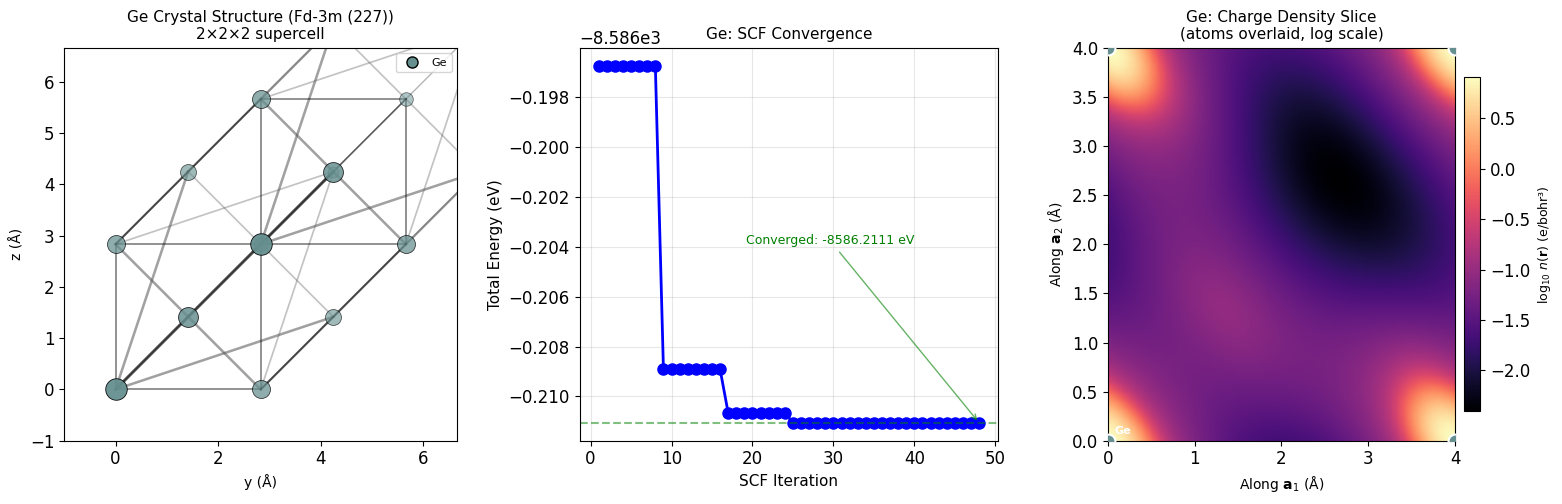


Figure saved: /home/niel/git/DFT_Tutorial/qe_workshop_complete/outputs/03_Ge_scf_20260208_174618/Ge_scf_results.png

Left:   Crystal structure with unit cell outline, bonds, and element-colored atoms.
Center: SCF total energy converging to the ground state.
Right:  Electron density on a plane through the atoms (log scale).
        Colored circles = atom positions. Bright regions between atoms = bonds.

For 3D isosurface visualization, open ge_scf_charge.cube in VESTA.


In [8]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import re
import numpy as np
from ase.data import covalent_radii, atomic_numbers
from ase.data.colors import jmol_colors
from ase.neighborlist import neighbor_list

# =============================================================================
# All plots derive from the `atoms` object (set in the SCF cell above).
# This works for ANY material — Si, Ge, Fe, SrTiO3, GaAs, etc.
# =============================================================================

fig, axes = plt.subplots(1, 3, figsize=(16, 5.2))

# =============================================================================
# Plot 1: Crystal Structure — automatic projection with unit cell + bonds
# =============================================================================
ax1 = axes[0]

# Build a supercell large enough to show the structure clearly
# Use 2×2×2 for small cells, 1×1×1 for large cells
n_atoms_prim = len(atoms)
rep = (2, 2, 2) if n_atoms_prim <= 8 else (1, 1, 1)
supercell = atoms * rep

# Get cell vectors of the ORIGINAL (non-repeated) cell for drawing outline
cell = atoms.get_cell()

# Choose projection: view along the shortest cell vector (best 2D view)
cell_lengths = np.linalg.norm(cell, axis=1)
view_axis = np.argmin(cell_lengths)  # project along this axis
# The other two axes define the plot plane
plane_axes = [i for i in range(3) if i != view_axis]

# Project positions onto the 2D plane
positions = supercell.get_positions()
symbols = supercell.get_chemical_symbols()
x_2d = positions[:, plane_axes[0]]
y_2d = positions[:, plane_axes[1]]
depth = positions[:, view_axis]

# Normalize depth for visual layering
d_range = depth.max() - depth.min()
d_norm = (depth - depth.min()) / (d_range + 1e-10) if d_range > 0.1 else np.zeros_like(depth)

# Draw unit cell outline (original cell projected)
cell_corners_frac = np.array([
    [0,0,0],[1,0,0],[0,1,0],[1,1,0],
    [0,0,1],[1,0,1],[0,1,1],[1,1,1]
], dtype=float)
cell_corners_cart = cell_corners_frac @ cell
cx = cell_corners_cart[:, plane_axes[0]]
cy = cell_corners_cart[:, plane_axes[1]]
# Draw the 12 edges of the unit cell
edges_idx = [(0,1),(0,2),(0,4),(1,3),(1,5),(2,3),(2,6),(3,7),(4,5),(4,6),(5,7),(6,7)]
for i1, i2 in edges_idx:
    ax1.plot([cx[i1], cx[i2]], [cy[i1], cy[i2]],
             'k-', linewidth=1.2, alpha=0.5, zorder=2)

# Find bonds using ASE neighbor list (works for any structure)
i_idx, j_idx, d_ij = neighbor_list('ijd', supercell, cutoff=3.5)
# Filter to unique pairs and reasonable bond lengths
unique_elements = list(set(symbols))
# Estimate max bond length from covalent radii
max_bond = 0
for e1 in unique_elements:
    for e2 in unique_elements:
        r1 = covalent_radii[atomic_numbers[e1]]
        r2 = covalent_radii[atomic_numbers[e2]]
        max_bond = max(max_bond, (r1 + r2) * 1.3)

for idx in range(len(i_idx)):
    ii, jj = i_idx[idx], j_idx[idx]
    if ii < jj and d_ij[idx] < max_bond:
        alpha_bond = 0.2 + 0.5 * (1.0 - 0.5 * (d_norm[ii] + d_norm[jj]))
        lw = 0.8 + 1.5 * (1.0 - 0.5 * (d_norm[ii] + d_norm[jj]))
        ax1.plot([x_2d[ii], x_2d[jj]], [y_2d[ii], y_2d[jj]],
                 color='#555555', linewidth=lw, alpha=alpha_bond, zorder=1)

# Draw atoms with element-specific colors (Jmol convention)
legend_handles = []
plotted_elements = set()
for i in range(len(x_2d)):
    Z = atomic_numbers[symbols[i]]
    color = jmol_colors[Z]
    size = 60 + 180 * (1.0 - d_norm[i])
    alpha = 0.4 + 0.55 * (1.0 - d_norm[i])
    ax1.scatter(x_2d[i], y_2d[i], s=size, c=[color],
                edgecolors='black', linewidths=0.6, alpha=alpha, zorder=4)
    if symbols[i] not in plotted_elements:
        plotted_elements.add(symbols[i])
        from matplotlib.lines import Line2D
        legend_handles.append(
            Line2D([0], [0], marker='o', color='w', markerfacecolor=color,
                   markeredgecolor='k', markersize=8, label=symbols[i]))

# Crop to show the original cell region with some padding
pad = 1.0  # Å
x_cell = cell_corners_cart[:, plane_axes[0]]
y_cell = cell_corners_cart[:, plane_axes[1]]
ax1.set_xlim(x_cell.min() - pad, x_cell.max() + pad)
ax1.set_ylim(y_cell.min() - pad, y_cell.max() + pad)
ax1.set_aspect('equal')

axis_labels = ['x', 'y', 'z']
ax1.set_xlabel(f'{axis_labels[plane_axes[0]]} (Å)', fontsize=10)
ax1.set_ylabel(f'{axis_labels[plane_axes[1]]} (Å)', fontsize=10)

# Get space group if spglib is available
sg_label = ''
import spglib
spg_cell = (atoms.get_cell().tolist(),
            atoms.get_scaled_positions().tolist(),
            atoms.get_atomic_numbers().tolist())
sg_info = spglib.get_spacegroup(spg_cell, symprec=0.1)
if sg_info:
    sg_label = f' ({sg_info})'

rep_str = f'{rep[0]}×{rep[1]}×{rep[2]}' if any(r > 1 for r in rep) else ''
title_extra = f'\n{rep_str} supercell' if rep_str else ''
ax1.set_title(f'{MATERIAL} Crystal Structure{sg_label}{title_extra}', fontsize=11)
if legend_handles:
    ax1.legend(handles=legend_handles, fontsize=8, loc='upper right', framealpha=0.8)

# =============================================================================
# Plot 2: SCF Energy Convergence
# =============================================================================
ax2 = axes[1]

scf_energies = []
for line in output.split('\n'):
    if 'total energy' in line and '!' not in line and 'estimated' not in line.lower():
        match = re.search(r'=\s+([-\d.]+)\s+Ry', line)
        if match:
            scf_energies.append(float(match.group(1)) * RY_TO_EV)

if scf_energies:
    iterations = range(1, len(scf_energies) + 1)
    ax2.plot(iterations, scf_energies, 'bo-', markersize=8, linewidth=2)
    ax2.set_xlabel('SCF Iteration', fontsize=11)
    ax2.set_ylabel('Total Energy (eV)', fontsize=11)
    ax2.set_title(f'{MATERIAL}: SCF Convergence', fontsize=11)
    ax2.grid(True, alpha=0.3)
    ax2.axhline(y=scf_energies[-1], color='g', linestyle='--', alpha=0.5)
    ax2.annotate(f'Converged: {scf_energies[-1]:.4f} eV',
                 xy=(len(scf_energies), scf_energies[-1]),
                 xytext=(len(scf_energies)*0.4, scf_energies[0]+(scf_energies[-1]-scf_energies[0])*0.5),
                 fontsize=9, color='green',
                 arrowprops=dict(arrowstyle='->', color='green', alpha=0.6))

# =============================================================================
# Plot 3: Charge Density with Atom Positions Overlaid (generic for any cell)
# =============================================================================
ax3 = axes[2]
density_plotted = False

if cube_file is not None and cube_file.exists():
    # ── Parse cube file (standard Gaussian cube format) ──
    with open(cube_file) as f:
        f.readline(); f.readline()  # comment lines
        parts = f.readline().split()
        n_atoms_cube = abs(int(parts[0]))
        origin = np.array([float(x) for x in parts[1:4]])

        grid_n = []
        grid_vec = []
        for _ in range(3):
            ln = f.readline().split()
            grid_n.append(int(ln[0]))
            grid_vec.append([float(x) for x in ln[1:4]])
        nx, ny, nz = grid_n
        dv = [np.array(v) for v in grid_vec]

        atom_Z_cube = []
        atom_pos_cube = []  # in bohr
        for _ in range(n_atoms_cube):
            aln = f.readline().split()
            atom_Z_cube.append(int(aln[0]))
            atom_pos_cube.append([float(aln[2]), float(aln[3]), float(aln[4])])

        data = []
        for line in f:
            data.extend(float(x) for x in line.split())

    density = np.array(data).reshape((nx, ny, nz))
    atom_pos_cube = np.array(atom_pos_cube)

    # Cell vectors from cube grid (bohr)
    cell_bohr = np.array([np.array(dv[i]) * grid_n[i] for i in range(3)])
    cell_inv_bohr = np.linalg.inv(cell_bohr.T)

    BOHR2ANG = 0.529177

    # ── Choose a slice plane that passes through atoms ──
    # Strategy: find the plane defined by the first two cell vectors
    # (this is the most natural slice for any cell geometry)
    # We sample a 2D grid in the plane spanned by cell_bohr[0] and cell_bohr[1],
    # at the fractional z-coordinate of the first atom (so the slice hits an atom).

    # Find fractional coords of all atoms
    atom_frac = np.array([cell_inv_bohr @ pos for pos in atom_pos_cube])
    atom_frac = atom_frac % 1.0  # wrap

    # Choose the slice at the z-fractional coordinate of the first atom
    z_frac_slice = atom_frac[0, 2]

    # Sample density on a 2D grid in the (a1, a2) plane at fixed frac_z
    n_pts = 150
    f1_arr = np.linspace(0, 1, n_pts)
    f2_arr = np.linspace(0, 1, n_pts)
    slice_density = np.zeros((n_pts, n_pts))

    for i1 in range(n_pts):
        for i2 in range(n_pts):
            frac = np.array([f1_arr[i1], f2_arr[i2], z_frac_slice])
            # Map fractional to grid indices
            gi = frac[0] * nx
            gj = frac[1] * ny
            gk = frac[2] * nz
            i0 = int(gi) % nx; j0 = int(gj) % ny; k0 = int(gk) % nz
            i1_ = (i0+1) % nx; j1_ = (j0+1) % ny; k1_ = (k0+1) % nz
            fi = gi - int(gi); fj = gj - int(gj); fk = gk - int(gk)
            val = (density[i0,j0,k0]*(1-fi)*(1-fj)*(1-fk) +
                   density[i1_,j0,k0]*fi*(1-fj)*(1-fk) +
                   density[i0,j1_,k0]*(1-fi)*fj*(1-fk) +
                   density[i0,j0,k1_]*(1-fi)*(1-fj)*fk +
                   density[i1_,j1_,k0]*fi*fj*(1-fk) +
                   density[i1_,j0,k1_]*fi*(1-fj)*fk +
                   density[i0,j1_,k1_]*(1-fi)*fj*fk +
                   density[i1_,j1_,k1_]*fi*fj*fk)
            slice_density[i1, i2] = val

    # Convert fractional grid to Cartesian (Å) for axis labels
    # Corner points of the slice in Cartesian
    c00 = np.array([0, 0, z_frac_slice]) @ cell_bohr * BOHR2ANG
    c10 = np.array([1, 0, z_frac_slice]) @ cell_bohr * BOHR2ANG
    c01 = np.array([0, 1, z_frac_slice]) @ cell_bohr * BOHR2ANG

    # For imshow, use fractional axes but label in Å
    a1_len = np.linalg.norm(cell_bohr[0]) * BOHR2ANG
    a2_len = np.linalg.norm(cell_bohr[1]) * BOHR2ANG

    # Log scale to reveal bonding charge
    slice_clipped = np.clip(slice_density, 1e-4, None)
    im = ax3.imshow(np.log10(slice_clipped).T, origin='lower', cmap='magma',
                    extent=[0, a1_len, 0, a2_len], aspect='auto',
                    interpolation='bilinear')
    cbar = plt.colorbar(im, ax=ax3, shrink=0.85, pad=0.02)
    cbar.set_label('log$_{10}$ $n(\\mathbf{r})$ (e/bohr³)', fontsize=9)

    # ── Overlay atom positions that lie near this slice plane ──
    tol_frac = 0.08  # atoms within this fractional distance of the slice
    atom_u_plot, atom_v_plot, atom_sym_plot = [], [], []
    # Check atoms and periodic images to fill the cell
    for sf1 in range(-1, 2):
        for sf2 in range(-1, 2):
            for ia in range(len(atom_frac)):
                af = atom_frac[ia].copy()
                af[0] += sf1
                af[1] += sf2
                # Check if near the slice plane
                dz = abs(af[2] - z_frac_slice)
                dz = min(dz, abs(dz - 1.0))  # periodic in z
                if dz < tol_frac:
                    # Convert to Cartesian position in the slice plane
                    au = af[0] * a1_len
                    av = af[1] * a2_len
                    if -0.5 <= au <= a1_len + 0.5 and -0.5 <= av <= a2_len + 0.5:
                        atom_u_plot.append(au)
                        atom_v_plot.append(av)
                        atom_sym_plot.append(atom_Z_cube[ia])

    if atom_u_plot:
        # Draw bonds between nearby atoms in the slice
        atom_pts = np.column_stack([atom_u_plot, atom_v_plot])
        for i in range(len(atom_pts)):
            for j in range(i+1, len(atom_pts)):
                d = np.linalg.norm(atom_pts[i] - atom_pts[j])
                if d < max_bond:
                    ax3.plot([atom_pts[i,0], atom_pts[j,0]],
                             [atom_pts[i,1], atom_pts[j,1]],
                             'w-', linewidth=1.5, alpha=0.6, zorder=4)

        # Draw atoms as circles with element-specific colors
        for i in range(len(atom_u_plot)):
            Z = atom_sym_plot[i]
            color = jmol_colors[Z]
            ax3.plot(atom_u_plot[i], atom_v_plot[i], 'o', markersize=10,
                     markerfacecolor=color, markeredgecolor='white',
                     markeredgewidth=1.5, zorder=5)

        # Label first instance of each element
        labeled = set()
        for i in range(len(atom_u_plot)):
            Z = atom_sym_plot[i]
            if Z not in labeled and 0 < atom_u_plot[i] < a1_len and 0 < atom_v_plot[i] < a2_len:
                from ase.data import chemical_symbols
                ax3.annotate(chemical_symbols[Z],
                             xy=(atom_u_plot[i], atom_v_plot[i]),
                             xytext=(5, 5), textcoords='offset points',
                             fontsize=8, color='white', fontweight='bold', zorder=6)
                labeled.add(Z)

    ax3.set_xlabel(f'Along $\\mathbf{{a}}_1$ (Å)', fontsize=10)
    ax3.set_ylabel(f'Along $\\mathbf{{a}}_2$ (Å)', fontsize=10)
    ax3.set_title(f'{MATERIAL}: Charge Density Slice\n(atoms overlaid, log scale)', fontsize=11)
    density_plotted = True

if not density_plotted:
    ax3.text(0.5, 0.5, 'Cube file not available.\nRun the pp.x cell above.',
             ha='center', va='center', fontsize=11, transform=ax3.transAxes)
    ax3.set_title('Electron Density', fontsize=11)

plt.tight_layout()
fig_path = work_dir / f'{MATERIAL}_scf_results.png'
fig.savefig(fig_path, dpi=150, bbox_inches='tight')
plt.show()

print(f"\nFigure saved: {fig_path}")
if density_plotted:
    print(f"\nLeft:   Crystal structure with unit cell outline, bonds, and element-colored atoms.")
    print(f"Center: SCF total energy converging to the ground state.")
    print(f"Right:  Electron density on a plane through the atoms (log scale).")
    print(f"        Colored circles = atom positions. Bright regions between atoms = bonds.")
    print(f"\nFor 3D isosurface visualization, open {cube_file.name} in VESTA.")

---

## Summary

Before running calculations, verify:

1. ✓ **Functional**: PBE for most, +U for d/f metals, HSE for gaps
2. ✓ **Pseudopotentials**: SSSP library, correct type (NC/US/PAW)
3. ✓ **Cutoffs**: Use PP recommendations, verify with convergence
4. ✓ **K-points**: Dense for metals, moderate for semiconductors

### Next Notebook
→ **04_Convergence_Testing.ipynb**: Systematic convergence tests